# House prices

Kairos (April 2018)


## Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.


## Data
79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

## Challenge
Predicting the final price of each home.

## Method
We'll use Tensorflow as out method to develop the project.

## Validation
In this exercise, we'll dive a bit more deeply into the training and evaluation of a model.

As in the prior exercises, we're working with the housing data set, to try and predict `SalePrice`.

We'll:
    1. Use multiple features, instead of a single feature, to further improve the effectiveness of a model
    2. Debug issues in model input data
    3. Use a test data set to check if a model is overfitting the validation data


## 1. Set Up
In this first cell, we'll load the necessary libraries.

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io


tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2. Load our data set
Next, we'll load our data set.

In [2]:
housing_dataframe = pd.read_csv("input/cleaned_houses_prices_train.csv", sep=",")

## 3. Choosing features

In [3]:
def preprocess_features(housing_dataframe):
  """Prepares input features from housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = housing_dataframe[
    ["MSZoning",
     "YearRemodAdd",
     "Utilities",
     "Neighborhood",
     "HouseStyle",
     "BedroomAbvGr",
     "OverallCond"]]
  processed_features = selected_features.copy()
  
  # Create a synthetic feature.
  # Create a new category for total habitable surface
  housing_dataframe["habitableSF"] = housing_dataframe["1stFlrSF"] + housing_dataframe["2ndFlrSF"] + housing_dataframe["GrLivArea"]
  housing_dataframe['SQMeter_price'] = housing_dataframe.apply(lambda row: row['SalePrice'] / row['habitableSF'], axis=1)
  
  # Create a new synthetic feature

  processed_features["SQMeter_price"] = housing_dataframe["SQMeter_price"] 
  return processed_features

def preprocess_targets(housing_dataframe):
  """Prepares target features (i.e., labels) from housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["SalePrice"] = (housing_dataframe["SalePrice"])
  return output_targets

## 4. Splitting the dataset into training and validation datasets
For the training set, we'll choose the first 1000 examples, out of the total of 1451.
We'll create an inter examples of 500.
Validation data will have 500.


In [4]:
training_examples = preprocess_features(housing_dataframe.head(1000))
training_targets = preprocess_targets(housing_dataframe.head(1000))

validation_examples = preprocess_features(housing_dataframe.tail(500))
validation_targets = preprocess_targets(housing_dataframe.tail(500))
training_examples

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,MSZoning,YearRemodAdd,Utilities,Neighborhood,HouseStyle,BedroomAbvGr,OverallCond,SQMeter_price
0,0,2003,0,0,0,3,5,61.0
1,0,1976,0,1,1,3,8,71.9
2,0,2002,0,0,0,3,5,62.6
3,0,1970,0,2,0,3,5,40.8
4,0,2000,0,3,0,4,5,56.9
...,...,...,...,...,...,...,...,...
995,0,1950,0,7,1,2,6,62.2
996,0,2006,0,5,1,3,5,73.7
997,0,1976,0,6,1,4,6,40.7
998,0,2006,0,21,1,1,5,60.2


## 5. Examine the data
Okay, let's look at the data above. We have several input features that we can use.

Take a quick skim over the table of values. Do they pass a quick sanity check?

Take a look at the data on your own. Everything look okay? See how many issues you can spot. Don't worry if you don't have a background in statistics; common sense is often enough.

After you've had a chance to look over the data yourself, check the solution for some additional thoughts on how to sanity check data.

Let's take a close look at two features in particular: latitude and longitude. These are geographical coordinates of the city block in question.

This might make a nice visualization — let's plot latitude and longitude, and use color to show the median_house_value.

In [5]:
housing_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 65 columns):
Id               1451 non-null int64
MSSubClass       1451 non-null int64
LotArea          1451 non-null int64
OverallQual      1451 non-null int64
OverallCond      1451 non-null int64
YearBuilt        1451 non-null int64
YearRemodAdd     1451 non-null int64
MasVnrArea       1451 non-null float64
BsmtFinSF1       1451 non-null int64
BsmtFinSF2       1451 non-null int64
BsmtUnfSF        1451 non-null int64
TotalBsmtSF      1451 non-null int64
1stFlrSF         1451 non-null int64
2ndFlrSF         1451 non-null int64
LowQualFinSF     1451 non-null int64
GrLivArea        1451 non-null int64
BsmtFullBath     1451 non-null int64
BsmtHalfBath     1451 non-null int64
FullBath         1451 non-null int64
HalfBath         1451 non-null int64
BedroomAbvGr     1451 non-null int64
KitchenAbvGr     1451 non-null int64
TotRmsAbvGrd     1451 non-null int64
Fireplaces       1451 non-null int64
Gar

## 6. Train the model


In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = tf.data.Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [7]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [8]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["SalePrice"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["SalePrice"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["SalePrice"], 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 197655.50
  period 01 : 196383.04
  period 02 : 195112.19
  period 03 : 193842.98
  period 04 : 192575.44
  period 05 : 191309.61
  period 06 : 190045.51
  period 07 : 188783.19
  period 08 : 187522.68
  period 09 : 186264.02
Model training finished.


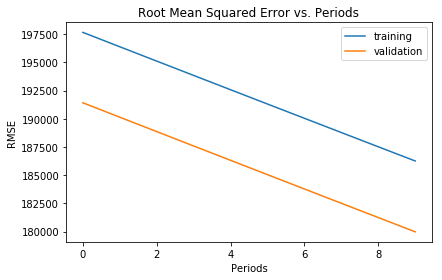

In [9]:
linear_regressor = train_model(
    learning_rate=0.004,
    steps=350,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## 7. Evaluate on Test Data
In the cell below, load in the test data set and evaluate your model on it.

We've done a lot of iteration on our validation data. Let's make sure we haven't overfit to the pecularities of that particular sample.

Test data set is located input/cleaned_houses_prices_train.csv.

How does your test performance compare to the validation performance? What does this say about the generalization performance of your model?



In [12]:
#test_examples.info()
#test_targets.info()
housing_test_data = pd.read_csv("input/cleaned_houses_prices_train.csv", sep=",")

test_examples = preprocess_features(housing_test_data)
test_targets = preprocess_targets(housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["SalePrice"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print "Final RMSE (on test data): %0.2f" % root_mean_squared_error


Final RMSE (on test data): 184583.73
